# Model Zoo -- Convolutional Netural Network

Nothing special here, just a basic cnn to test out the dataset.

## Imports

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb

import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torchsummary

from tqdm import tnrange, tqdm_notebook

In [2]:
from pathlib import Path

## Settings and Dataset

In [3]:
#############################
## Settings
#############################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
img_size = 128
learning_rate = 0.05
num_epochs = 10
batch_size = 64

# Architecture
num_classes = 10

In [4]:
def unnormalize(image):
    """
        Convert imagenet's normalzied tensor into PIL image to be displayed
    """
    image = image * torch.Tensor([0.229, 0.224, 0.225]).view((3,1,1)) + torch.Tensor([0.485, 0.456, 0.406]).view((3,1,1))
    return transforms.ToPILImage()(image)

In [5]:
################################
## Imagenette Dataset
################################
## TODO: Need to resize images to maatch. img_size = 124?

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
resize = transforms.Resize((img_size, img_size))  # images be resized into squares

data_transforms = {
    'train': transforms.Compose([
             resize,
             transforms.ToTensor(),
             normalize
    ]),
    'val': transforms.Compose([
           resize,
           transforms.ToTensor(),
           normalize
    ])
}

data_dir = Path('data/imagenette')

image_datasets = {x: datasets.ImageFolder(data_dir/x, data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=batch_size, 
                                              shuffle= x=='train', 
                                              num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [6]:
# Checking the dataset
for name in ['train', 'val']:
    print(f'{name} : {len(image_datasets[name]):,}')

train : 12,894
val : 500


In [7]:
# image_datasets['train'].class_to_idx

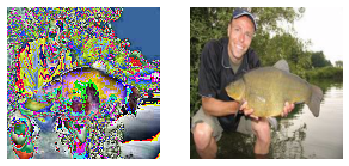

In [8]:
_, axes = plt.subplots(1,2)
for ax, func in zip(axes, [transforms.ToPILImage(), unnormalize]):
    ax.imshow(func(image_datasets['train'][1][0]))
    ax.axis('off')

## Model

In [16]:
######################
### Model
######################

## TODO: I think the channels out are wrong
## TODO: After notebook can run, create the train/val split notebook
## TODO: Look into adaptive pooling and how fastai determine number of parametsr for linear layer

class ConvNet(torch.nn.Module):
    
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        # calculate same padding:
        # (w -k + 2*p)/s + 1 = 0
        # => p = (s(o-1)) - w + k)/2
        
        # 128x128x3 => 128x128x4
        self.conv_1 = torch.nn.Conv2d(in_channels=3, 
                                      out_channels=4,
                                      kernel_size=(3,3),
                                      stride=(1,1),
                                      padding=1)  # (1(28-1) - 28 + 3) / 2 = 1
        
        # 128x128x4 => 64x64x4
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2,2),
                                         stride=(2,2),
                                         padding=0)  # (2(14-1) - 28 + 2) = 0
        
        # 64x64x4 => 64x64x16
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=16,
                                      kernel_size=(3,3),
                                      stride=(1,1),
                                      padding=1) # (1(14-1) - 14 + 4) / 2 = 1
        
        # 64x64x16 => 32x32x16
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2,2),
                                         stride=(2,2),
                                         padding=0) # (2(2-1) - 14 +2) = 0
        
        self.linear_1 = torch.nn.Linear(32*32*16, num_classes)
        
        # optionally initialize weights from Gaussian;
        # Guassian weight init is not recommended and only for demonstration purposes
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                m.weight.data.normal_(0.0, 0.01)
                m.bias.data.zero_()
                if m.bias is not None:
                    m.bias.detach().zero_()
                    
    def forward(self, x):
        out = self.conv_1(x)
        out = F.relu(out)
        out = self.pool_1(out)

        out = self.conv_2(out)
        out = F.relu(out)
        out = self.pool_2(out)

        logits = self.linear_1(out.view(-1, 32*32*16))
        return logits

In [17]:
model = ConvNet(num_classes=num_classes)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [18]:
torchsummary.summary(model, (3, 128, 128), batch_size=batch_size, device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [64, 4, 128, 128]             112
         MaxPool2d-2            [64, 4, 64, 64]               0
            Conv2d-3           [64, 16, 64, 64]             592
         MaxPool2d-4           [64, 16, 32, 32]               0
            Linear-5                   [64, 10]         163,850
Total params: 164,554
Trainable params: 164,554
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 12.00
Forward/backward pass size (MB): 80.00
Params size (MB): 0.63
Estimated Total Size (MB): 92.63
----------------------------------------------------------------


## Training

In [12]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [13]:
## create a train_model function isntead of current approach. 

## need to calcualte the cost functionf or validation

## Need to make sure I have tdmp notebook updator

## for print out
## just end of epoch, validation
# time between each epoch?
# or just total time...?


## For graph
## save all batch.
## when of epoch as darker dot
## also save validation set
## 

In [19]:
criterion = torch.nn.CrossEntropyLoss()

In [20]:
def train_model(model, criterion, optimizer, dataloaders, scheduler=None, num_epochs=25):
    since = time.time()
    
    batch_loss_record = []
    val_loss_record = []
    
    for epoch in tnrange(num_epochs):
        print(f'Epoch {epoch:03d}/{num_epochs - 1:03d}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler: scheduler.step()
                model.train()
            else:
                model.eval()
                running_loss = 0.0
                running_corrects = 0
                
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        batch_loss_record.append(loss.item())
                    else:
                        # validation
                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)

                
            if phase == 'train':
#                 pdb.set_trace()
                print(f'{phase} Batch Loss: {loss.item():.4f} Batch Acc: {torch.sum(preds == labels).double() / inputs.size(0):.4f}', end = " | ")
            else:
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                val_loss_record.append(epoch_loss)
        
    time_elapsed = time.time() - since
    print('training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    return batch_loss_record, val_loss_record

In [21]:
batch_loss, val_loss = train_model(model, criterion, optimizer, dataloaders, num_epochs=10)

Epoch 000/009
----------
train Batch Loss: 2.1034 Batch Acc: 0.2333 | val Loss: 2.0499 Acc: 0.3160
Epoch 001/009
----------
train Batch Loss: 2.1038 Batch Acc: 0.3000 | val Loss: 1.9319 Acc: 0.3700
Epoch 002/009
----------
train Batch Loss: 2.1118 Batch Acc: 0.3667 | val Loss: 1.6595 Acc: 0.4500
Epoch 003/009
----------
train Batch Loss: 1.4079 Batch Acc: 0.5000 | val Loss: 1.5884 Acc: 0.4660
Epoch 004/009
----------
train Batch Loss: 1.4217 Batch Acc: 0.4667 | val Loss: 1.5222 Acc: 0.5460
Epoch 005/009
----------
train Batch Loss: 1.0652 Batch Acc: 0.6333 | val Loss: 1.7024 Acc: 0.4720
Epoch 006/009
----------
train Batch Loss: 1.0733 Batch Acc: 0.6000 | val Loss: 1.4763 Acc: 0.5380
Epoch 007/009
----------
train Batch Loss: 1.0479 Batch Acc: 0.7000 | val Loss: 1.5422 Acc: 0.5200
Epoch 008/009
----------
train Batch Loss: 0.9393 Batch Acc: 0.6333 | val Loss: 1.4739 Acc: 0.5600
Epoch 009/009
----------
train Batch Loss: 0.6175 Batch Acc: 0.8667 | val Loss: 1.8032 Acc: 0.4980

training 

In [18]:
batch_loss, val_loss = train_model(model, criterion, optimizer, dataloaders, num_epochs=10)

Epoch 000/009
----------
train Batch Loss: 0.6684 Batch Acc: 0.7708 | val Loss: 0.6586 Acc: 0.7688
Epoch 001/009
----------
train Batch Loss: 0.2970 Batch Acc: 0.9271 | val Loss: 0.2508 Acc: 0.9262
Epoch 002/009
----------
train Batch Loss: 0.0478 Batch Acc: 1.0000 | val Loss: 0.1503 Acc: 0.9547
Epoch 003/009
----------
train Batch Loss: 0.1391 Batch Acc: 0.9479 | val Loss: 0.1183 Acc: 0.9638
Epoch 004/009
----------
train Batch Loss: 0.0768 Batch Acc: 0.9792 | val Loss: 0.0949 Acc: 0.9714
Epoch 005/009
----------
train Batch Loss: 0.0808 Batch Acc: 0.9583 | val Loss: 0.0877 Acc: 0.9735
Epoch 006/009
----------
train Batch Loss: 0.0424 Batch Acc: 0.9792 | val Loss: 0.0811 Acc: 0.9733
Epoch 007/009
----------
train Batch Loss: 0.0966 Batch Acc: 0.9688 | val Loss: 0.0828 Acc: 0.9738
Epoch 008/009
----------
train Batch Loss: 0.0727 Batch Acc: 0.9792 | val Loss: 0.0641 Acc: 0.9785
Epoch 009/009
----------
train Batch Loss: 0.1043 Batch Acc: 0.9688 | val Loss: 0.0654 Acc: 0.9789

training 

In [18]:
batch_loss, val_loss = train_model(model, criterion, optimizer, dataloaders, num_epochs=10)

Epoch 000/009
----------
train Batch Loss: 2.3068 Batch Acc: 0.0833 | val Loss: 2.3010 Acc: 0.1135
Epoch 001/009
----------
train Batch Loss: 2.3124 Batch Acc: 0.0625 | val Loss: 2.3004 Acc: 0.1135
Epoch 002/009
----------
train Batch Loss: 0.3391 Batch Acc: 0.8958 | val Loss: 0.3971 Acc: 0.8827
Epoch 003/009
----------
train Batch Loss: 0.2923 Batch Acc: 0.8958 | val Loss: 0.2381 Acc: 0.9261
Epoch 004/009
----------
train Batch Loss: 0.1450 Batch Acc: 0.9479 | val Loss: 0.1276 Acc: 0.9617
Epoch 005/009
----------
train Batch Loss: 0.2747 Batch Acc: 0.9583 | val Loss: 0.1037 Acc: 0.9679
Epoch 006/009
----------
train Batch Loss: 0.1809 Batch Acc: 0.9271 | val Loss: 0.0908 Acc: 0.9710
Epoch 007/009
----------
train Batch Loss: 0.0801 Batch Acc: 0.9583 | val Loss: 0.0896 Acc: 0.9688
Epoch 008/009
----------
train Batch Loss: 0.0755 Batch Acc: 0.9792 | val Loss: 0.0692 Acc: 0.9759
Epoch 009/009
----------
train Batch Loss: 0.0976 Batch Acc: 0.9896 | val Loss: 0.0713 Acc: 0.9761

training 

In [20]:
tmp = torch.randint(0, 10, size=(2,3,4))

In [23]:
tmp

tensor([[[8, 1, 8, 8],
         [7, 7, 7, 4],
         [5, 6, 2, 8]],

        [[0, 2, 3, 0],
         [0, 3, 6, 8],
         [0, 0, 2, 9]]])

In [24]:
tmp.data

tensor([[[8, 1, 8, 8],
         [7, 7, 7, 4],
         [5, 6, 2, 8]],

        [[0, 2, 3, 0],
         [0, 3, 6, 8],
         [0, 0, 2, 9]]])

In [16]:
batch_loss, val_loss = train_model(model, criterion, optimizer, dataloaders, num_epochs=10)

Epoch 000/009
----------
train Batch Loss: 2.2919 Batch Acc: 0.0000 | val Loss: 2.2808 Acc: 0.2452
Epoch 001/009
----------
train Batch Loss: 0.2125 Batch Acc: 0.0000 | val Loss: 0.2333 Acc: 0.9337
Epoch 002/009
----------
train Batch Loss: 0.2638 Batch Acc: 0.0000 | val Loss: 0.1556 Acc: 0.9523
Epoch 003/009
----------
train Batch Loss: 0.1145 Batch Acc: 0.0000 | val Loss: 0.1213 Acc: 0.9625
Epoch 004/009
----------
train Batch Loss: 0.0463 Batch Acc: 0.0000 | val Loss: 0.0966 Acc: 0.9695
Epoch 005/009
----------
train Batch Loss: 0.1713 Batch Acc: 0.0000 | val Loss: 0.0891 Acc: 0.9716
Epoch 006/009
----------
train Batch Loss: 0.0745 Batch Acc: 0.0000 | val Loss: 0.0967 Acc: 0.9676
Epoch 007/009
----------
train Batch Loss: 0.0408 Batch Acc: 0.0000 | val Loss: 0.0740 Acc: 0.9764
Epoch 008/009
----------
train Batch Loss: 0.2236 Batch Acc: 0.0000 | val Loss: 0.1028 Acc: 0.9659
Epoch 009/009
----------
train Batch Loss: 0.0462 Batch Acc: 1.0000 | val Loss: 0.0658 Acc: 0.9792

training 

In [19]:
len(batch_loss)

4690

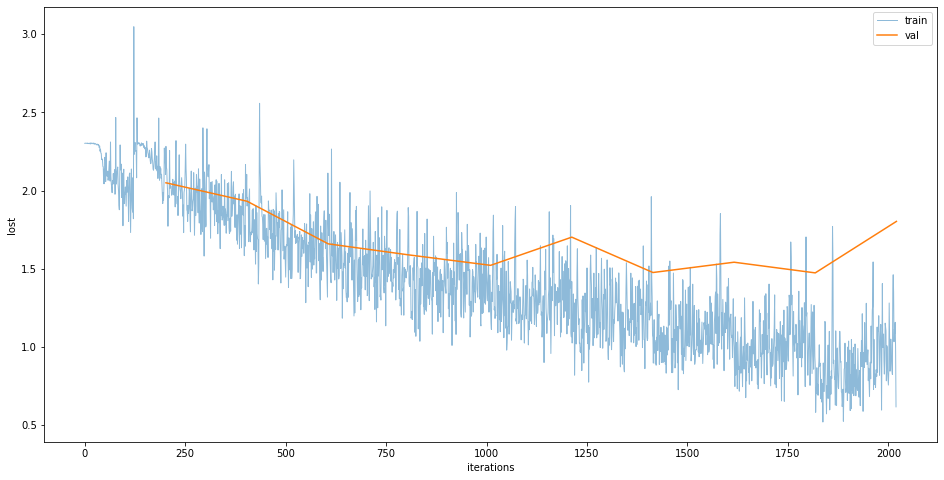

In [22]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(np.arange(len(batch_loss)), batch_loss, linewidth=1, alpha=.5, label='train')
ax.plot(np.arange(1, num_epochs+1)*len(dataloaders['train']), val_loss, label='val')
plt.xlabel('iterations')
plt.ylabel('lost')
ax.legend();